# Loading original dataset

In [240]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from datetime import date
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import axes3d
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc
import pandas as pd
from datetime import date
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.random.seed(r)

dataset = pd.read_csv("../common/dataset.csv", header=0, index_col='CUST_COD')
# Backup original dataset
orig_dataset = dataset.copy()

print(dataset.shape)

(26884, 24)


In [3]:
orig_dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [4]:
orig_dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


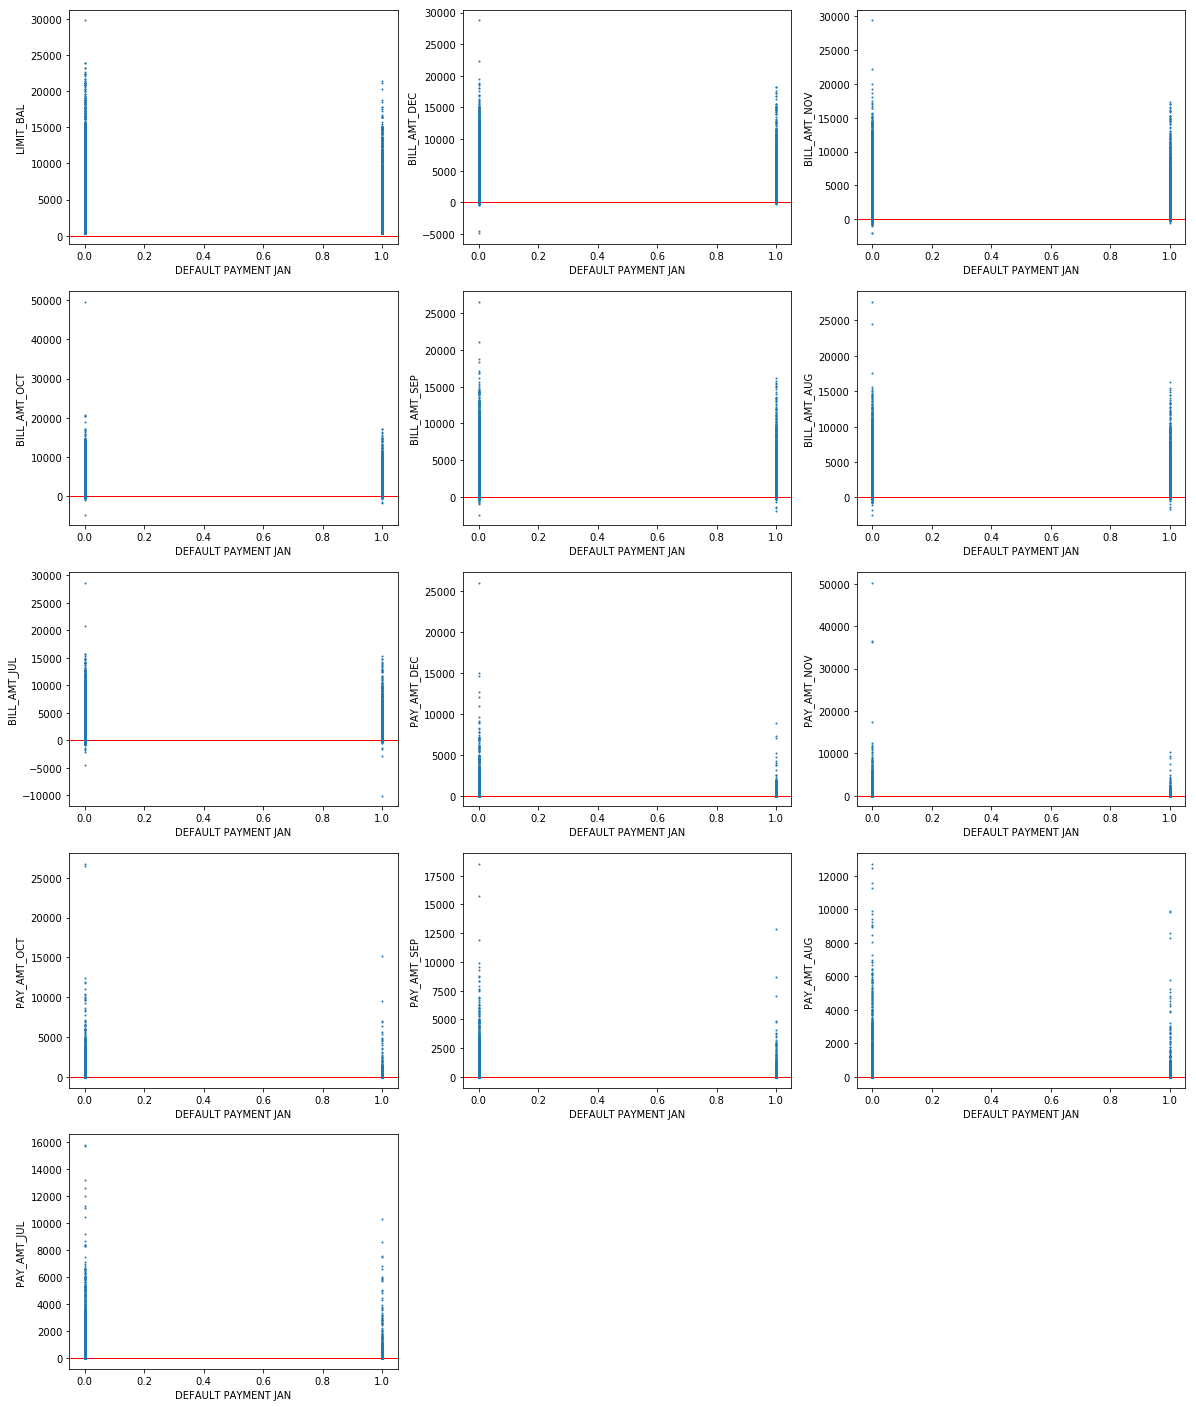

In [5]:
fig = plt.figure(figsize=(20,25))
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(5,3,i)
    i += 1
    ax.set_xlabel('DEFAULT PAYMENT JAN')
    ax.set_ylabel(col_name)
    ax.scatter(orig_dataset['DEFAULT PAYMENT JAN'], orig_dataset[col_name], s=1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

               0     1
PAY_AUG_0  12307  2870
PAY_JUL_0  11834  2747
PAY_SEP_0  12022  2707
PAY_OCT_0  11624  2476
PAY_NOV_0  11825  2252
PAY_NOV_2   1581  1957
PAY_OCT_2   1679  1748
PAY_DEC_0  11490  1694
PAY_DEC_2    740  1659
PAY_SEP_2   1371  1474


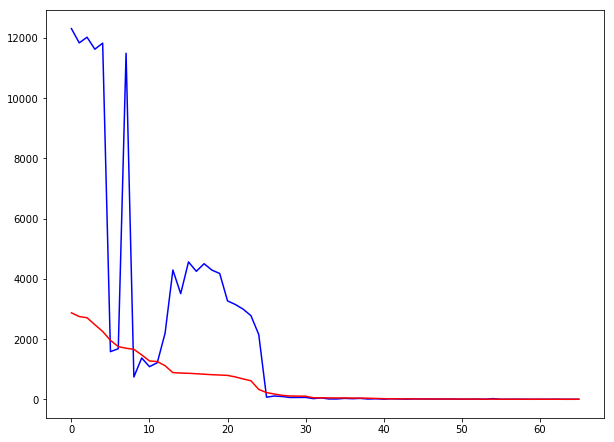

In [6]:
fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
df = pd.DataFrame()
for field in fields:
    for j in [0]:
        for i in np.arange(-2,9):
            df['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df1 = pd.DataFrame(df.sum())

df2 = pd.DataFrame()
for field in fields:
    for j in [1]:
        for i in np.arange(-2,9):
            df2['{}_{}'.format(field, i, j)] = (orig_dataset[field] == i) & (orig_dataset['DEFAULT PAYMENT JAN'] == j)
df3 = pd.DataFrame(df2.sum())
df3.rename(columns={0: 1}, inplace=True)

df9999 = pd.concat([df1, df3], axis=1).sort_values([1], ascending = 0)
# df9999 = df9999.div(df9999.sum(axis=1), axis=0)
df9999 = df9999.sort_values([1], ascending = 0)

#df9999.head(10000)
print(df9999.head(10))
fig = plt.figure()
plt.plot(df9999[0].tolist(), c='b')
plt.plot(df9999[1].tolist(), c='r')
plt.show()

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [7]:
# Format: {'name' : X_name}
X_dict = {}
# Format: {'name' : y_name}
y_dict = {}
# Format: {'name' : X_test_name}
X_test_dict = {}
# Format: {'name' : y_test_name}
y_test_dict = {}
names = set()

target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(dataset, name):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name].tolist()
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name].tolist()
    add_dataset(X, y, X_test, y_test, name)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))

def add_dataset(X, y, X_test, y_test, name):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name])

split_and_add(dataset=orig_dataset, name='orig')
split_and_add(dataset=orig_dataset.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE'], 1), name='baseline')

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [8]:
def transform_features(X_orig):
    X = X_orig.copy()
    print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = {'SEX'}
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
    marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    print('Computing AGE and dropping BIRTH_DATE')
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'], format='%d/%m/%Y')
    
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())

    months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
    for month in months:
        f = 'BILL_AMT_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['BILL_AMT_{}'.format(month)] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        f = 'LIMIT_BAL_MINUS_BILL_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)]
        fields.append(f)
        f = 'LIMIT_BAL_MINUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['PAY_AMT_{}'.format(month)]
        fields.append(f)
        f = 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_{}'.format(month)
        X[f] = X['LIMIT_BAL'] - X['BILL_AMT_{}'.format(month)] + X['PAY_AMT_{}'.format(month)]
        fields.append(f)
    
    print('Normalizing {}'.format(fields))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative number
    X[fields] = X[fields].apply(lambda x: x.apply(lambda y: np.cbrt(y)))
    #max_euro = dataset[fields].max().max()
    #min_euro = dataset[fields].min().min()
    #dataset[fields] = dataset[fields].apply(lambda x: x.apply(lambda y: (y-min_euro)/(max_euro-min_euro)))

    fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
    print('Normalizing {}'.format(fields))
    X[fields] = X[fields].apply(lambda x : x.apply(lambda y : (y + 2) / 10))

    print('Normalizing AGE')
    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age))
    
    print('Dataset prepared')
    print(X.shape)
    
    return X.copy()

In [172]:
X, y, X_test, y_test = retrieve_dataset(name='orig')
add_dataset(transform_features(X), y, transform_features(X_test), y_test, 'ale')
X, y, X_test, y_test = retrieve_dataset(name='ale')
X.head(5)

One hot encoding SEX feature
Scoring EDUCATION and MARRIAGE features
Computing AGE and dropping BIRTH_DATE
Normalizing ['LIMIT_BAL', 'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'BILL_AMT_MINUS_PAY_AMT_JUL', 'LIMIT_BAL_MINUS_BILL_AMT_JUL', 'LIMIT_BAL_MINUS_PAY_AMT_JUL', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_JUL', 'BILL_AMT_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_AUG', 'LIMIT_BAL_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_AUG', 'BILL_AMT_MINUS_PAY_AMT_SEP', 'LIMIT_BAL_MINUS_BILL_AMT_SEP', 'LIMIT_BAL_MINUS_PAY_AMT_SEP', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_SEP', 'BILL_AMT_MINUS_PAY_AMT_OCT', 'LIMIT_BAL_MINUS_BILL_AMT_OCT', 'LIMIT_BAL_MINUS_PAY_AMT_OCT', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT', 'BILL_AMT_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_NOV', 'LIMIT_BAL_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_A

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.5,0.1,0.3,0.4,0.4,0.4,0.4,0.0,4.951950,...,13.359703,12.894522,-2.667993,13.142260,13.105506,13.396240,4.951950,13.130166,13.360872,13.130166
21308338,8.416822,1.0,0.1,0.2,0.2,0.2,0.2,0.2,0.2,7.777672,...,8.200910,3.956249,8.144970,-1.546246,8.126352,3.824275,6.850009,5.010426,7.647190,6.501787
54049646,17.507695,0.1,1.0,0.2,0.2,0.2,0.2,0.2,0.2,14.005143,...,17.404867,13.810163,13.766778,13.765100,17.343996,14.022601,13.805107,13.784845,17.380589,13.985457
10396398,9.634856,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,2.706525,...,9.634856,9.634856,0.000000,9.634856,9.634856,9.634856,2.706525,9.563132,9.634856,9.563132
11528589,14.857157,0.5,1.0,0.2,0.2,0.2,0.2,0.2,0.2,11.382419,...,14.720845,13.274978,10.365809,12.757330,14.720845,12.937948,11.146928,12.175198,14.720524,12.373542


In [ ]:
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
          'BILL_AMT_MINUS_PAY_AMT_JUL', 'LIMIT_BAL_MINUS_BILL_AMT_JUL', 'LIMIT_BAL_MINUS_PAY_AMT_JUL', 
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_JUL', 'BILL_AMT_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_AUG',
          'LIMIT_BAL_MINUS_PAY_AMT_AUG', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_AUG', 'BILL_AMT_MINUS_PAY_AMT_SEP',
          'LIMIT_BAL_MINUS_BILL_AMT_SEP', 'LIMIT_BAL_MINUS_PAY_AMT_SEP', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_SEP',
          'BILL_AMT_MINUS_PAY_AMT_OCT', 'LIMIT_BAL_MINUS_BILL_AMT_OCT', 'LIMIT_BAL_MINUS_PAY_AMT_OCT',
          'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT', 'BILL_AMT_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_NOV',
          'LIMIT_BAL_MINUS_PAY_AMT_NOV', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV', 'BILL_AMT_MINUS_PAY_AMT_DEC',
          'LIMIT_BAL_MINUS_BILL_AMT_DEC', 'LIMIT_BAL_MINUS_PAY_AMT_DEC', 'LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC']
# print(len(fields))
# 40 fields
i = 1
fig = plt.figure(figsize=(20,85))
for col_name in fields:
    ax = fig.add_subplot(14, 3, i)
    i += 1
    # ax.set_xlabel('DEFAULT PAYMENT JAN')
    ax.set_ylabel(col_name)
    ax.scatter(y, X[col_name], s=1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

In [173]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,LIMIT_BAL_MINUS_PAY_AMT_OCT,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_OCT,BILL_AMT_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_NOV,LIMIT_BAL_MINUS_PAY_AMT_NOV,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_NOV,BILL_AMT_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_DEC,LIMIT_BAL_MINUS_PAY_AMT_DEC,LIMIT_BAL_MINUS_BILL_AMT_PLUS_PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.603,0.505,0.199,0.187,0.184,0.179,0.174,0.172,8.935,...,15.612,12.938,7.107,12.053,15.567,12.752,7.395,11.808,15.572,12.552
std,4.610,0.328,0.449,0.112,0.119,0.120,0.118,0.114,0.116,5.485,...,4.698,6.621,7.260,7.419,4.760,6.786,7.169,7.611,4.759,6.936
min,6.680,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-17.027,...,-10.058,-20.003,-28.119,-20.849,-27.754,-20.373,-27.141,-20.006,-18.283,-19.565
25%,11.423,0.500,0.100,0.100,0.100,0.100,0.100,0.100,0.100,4.830,...,11.423,8.179,2.181,6.908,11.423,7.664,2.901,6.484,11.423,7.362
50%,16.101,0.500,0.100,0.200,0.200,0.200,0.200,0.200,0.200,8.856,...,15.939,13.208,8.200,12.707,15.907,13.033,8.320,12.400,15.895,12.779
75%,19.270,1.000,1.000,0.200,0.200,0.200,0.200,0.200,0.200,12.646,...,19.015,18.143,12.137,18.079,18.998,18.140,12.343,18.016,18.998,18.133
max,28.172,1.000,1.000,1.000,0.900,1.000,0.900,0.900,1.000,28.133,...,28.139,29.263,27.838,28.051,28.143,33.453,27.873,28.053,28.087,30.909


# Preliminary Tests

In [ ]:
X, y, X_test, y_test = retrieve_dataset(name='orig')

y_pred = X_test['PAY_AMT_DEC'] < X_test['BILL_AMT_DEC']
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_pred = (X_test['PAY_DEC'] > 0)
y_pred &= (X_test['PAY_AMT_DEC'] < X_test['BILL_AMT_DEC'] + 1000)
y_pred &= (X_test['PAY_AMT_NOV'] < X_test['BILL_AMT_NOV'] + 1000)
y_pred &= (X_test['PAY_AMT_OCT'] < X_test['BILL_AMT_OCT'] + 1000)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

y_pred = (X_test['PAY_DEC'] > 0)
y_pred &= (X_test['PAY_NOV'] > 0)
y_pred &= (X_test['PAY_OCT'] > 0)
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

# plt.figure()
# print(confusion_matrix(X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'],
#                                  X['PAY_AMT_NOV'] < X['BILL_AMT_NOV']))
# print(confusion_matrix(X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'],
#                                  X['PAY_AMT_OCT'] < X['BILL_AMT_OCT']))
# print(confusion_matrix(X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'],
#                                  X['PAY_AMT_AUG'] < X['BILL_AMT_AUG']))
# plt.scatter(X['DEFAULT PAYMENT JAN'], X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'], s=1)

# plt.axhline(y=0, c='red', linewidth=1, zorder=0)
# plt.show()

In [ ]:
X = orig_dataset
m = [X['PAY_AMT_JUL'].median(),
     X['PAY_AMT_AUG'].median(),
     X['PAY_AMT_SEP'].median(),
     X['PAY_AMT_OCT'].median(),
     X['PAY_AMT_NOV'].median(),
     X['PAY_AMT_DEC'].median()]

plt.figure()
plt.plot(m)
plt.show()

m = [X['BILL_AMT_JUL'].median(),
     X['BILL_AMT_AUG'].median(),
     X['BILL_AMT_SEP'].median(),
     X['BILL_AMT_OCT'].median(),
     X['BILL_AMT_NOV'].median(),
     X['BILL_AMT_DEC'].median()]

plt.figure()
plt.plot(m)
plt.show()


In [ ]:
for col_name in sorted(set(X.columns).intersection(set(orig_dataset.columns))):
    if (col_name in {'EDUCATION', 'MARRIAGE', 'SEX'}):
        continue
    fig, axarr = plt.subplots(1, 2, figsize=(20,5))
    axarr[0].hist(orig_dataset[col_name], 50, normed=1, facecolor='b', alpha=0.75)
    axarr[0].set_xlabel('Value')
    axarr[0].set_ylabel('Density')
    axarr[0].set_title('orig_dataset[{}]'.format(col_name))

    axarr[1].hist(X[col_name], 50, normed=1, facecolor='y', alpha=0.75)
    axarr[1].set_xlabel('Value')
    axarr[1].set_ylabel('Density')
    axarr[1].set_title('X[{}]'.format(col_name))

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

    plt.show()


# Alessandro's - PCA

In [ ]:
X, y, X_test, y_test = retrieve_dataset('ale')

pca = PCA(whiten=False, random_state=r, n_components=2)
pca.fit(X)
colors = {0: 'b', 1: 'r'}
sizes = {0: 0.25, 1: 0.5}

plt.figure()
df = pd.DataFrame(pca.transform(X))
plt.scatter(df[0], df[1], c=pd.DataFrame(y)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
plt.show()

plt.figure()
df = pd.DataFrame(pca.transform(X_test))
plt.scatter(df[0], df[1], c=pd.DataFrame(y)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
plt.show() 

print('Printing PCA with 3 components to visualize dataset')
pca = PCA(whiten=False, random_state=r, n_components=3)
pca.fit(X)
colors = {0: 'b', 1: 'r'}
sizes = {0: 1, 1: 5}

df = pd.DataFrame(pca.transform(X))

#fig = plt.figure()
# fig, axarr = plt.subplots(nrows=4, ncols=5, figsize=(20,5), projection='3d')
for ii in np.arange(0,360,45):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
    plt.show()
    
df = pd.DataFrame(pca.transform(X_test))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, 'PCA 3D Test', transform=ax.transAxes)
ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y_test)[0].apply(lambda x: colors[x]), s=pd.DataFrame(y)[0].apply(lambda x: sizes[x]))
plt.show()



# PCA

Starting PCA
cumsum_tresh = 0.8, n_components = 1
cumsum_tresh = 0.85, n_components = 3
cumsum_tresh = 0.9, n_components = 5
cumsum_tresh = 0.95, n_components = 8
cumsum_tresh = 0.97, n_components = 11
cumsum_tresh = 0.99, n_components = 18


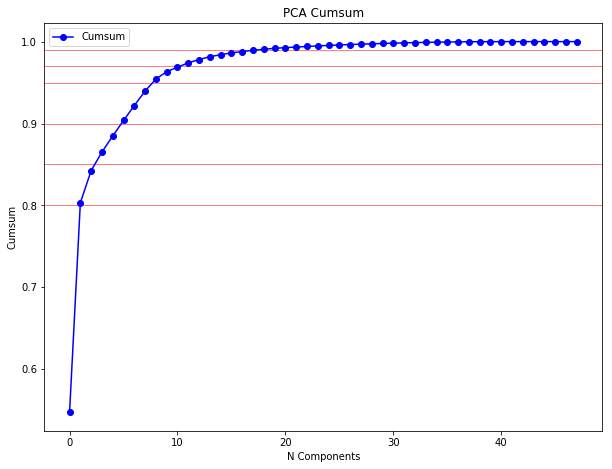

Selecting tresh = 0.99 -> n_components = 18


In [192]:
pca_enabled = True
if pca_enabled:
    X, y, X_test, y_test = retrieve_dataset('ale')
    print('Starting PCA')
    pca = PCA(whiten=False, random_state=r)
    pca.fit(X)
    cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))
 
    def find_cumsum_tresh(cumsum, cumsum_tresh):
        for i in np.arange(0, len(cumsum)):
            if cumsum[i] >= cumsum_tresh:
                break
        return i
    
    plt.figure(1)
    # plt.grid(color='k', linestyle='-', linewidth=0.5)
    plt.plot(cumsum, label='Cumsum', marker='o', color='b')
    plt.xlabel('N Components')
    plt.ylabel('Cumsum')
    plt.title('PCA Cumsum')
    plt.legend(loc='best')
    
    for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
        n_components = find_cumsum_tresh(cumsum, i)
        print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
        plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

    plt.show()
    
    tresh = 0.99
    
    n_components = find_cumsum_tresh(cumsum, tresh)
    print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
    pca = PCA(whiten=False, random_state=r, n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca_test = pca.transform(X_test)
    
    add_dataset(X_pca, y, X_pca_test, y_test, 'ale_pca')

In [193]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
pd.DataFrame(X).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-5.655363,-16.741521,1.968395,4.089071,4.500067,-4.702581,-4.854643,-5.148736,-0.039669,1.329112,-1.386235,1.759350,2.192799,-0.259567,-1.882837,-0.017126,-0.559786,0.402089
1,37.906203,-17.465561,-7.012722,1.201821,-1.825650,1.100008,0.402350,-0.259437,0.538063,-4.801036,-1.849707,0.857897,3.646820,0.899872,1.005854,-1.224485,-0.761046,-0.472769
2,4.931386,21.467797,-2.936029,-1.775877,0.663034,0.391141,-0.252974,-3.517001,-1.974619,0.625706,0.196658,-0.869907,-0.279576,0.064855,-0.258508,0.235881,-0.127194,0.169702
3,3.753047,-32.481071,1.055046,-3.198698,1.425674,-1.381677,-0.713480,-2.862009,0.927073,0.154513,0.006948,-0.880880,0.204688,0.089123,0.626597,0.122861,0.421309,-0.275019
4,4.795902,7.070248,-1.798195,-2.150233,0.142587,-0.377300,-0.437793,-1.938952,-3.829515,1.126956,0.489391,-0.893300,-0.340801,0.442937,0.210899,0.021112,0.083876,-0.113748


In [194]:
pd.DataFrame(X).describe().round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000
std,25.737,17.597,6.873,5.244,4.875,4.779,4.706,4.615,4.221,3.299,2.569,2.539,2.205,2.046,1.709,1.646,1.418,1.305
min,-64.704,-45.575,-46.798,-27.728,-39.162,-44.493,-33.966,-15.409,-26.441,-28.106,-21.481,-18.672,-19.510,-17.646,-13.293,-20.361,-11.769,-8.038
25%,-22.647,-12.388,-3.851,-2.545,-1.271,-1.426,-1.452,-3.241,-2.344,-1.429,-1.124,-1.184,-0.640,-0.537,-0.718,-0.415,-0.630,-0.586
50%,2.545,-3.291,-0.768,-1.018,0.193,-0.063,-0.327,-1.141,-0.637,0.359,0.270,-0.301,-0.125,0.089,0.018,-0.005,-0.098,-0.046
75%,21.217,10.706,3.056,1.778,1.312,1.226,1.132,2.199,2.284,1.634,1.180,1.028,0.567,0.511,0.717,0.301,0.648,0.590
max,106.023,65.439,58.994,54.221,41.014,45.583,41.808,33.126,32.356,30.241,22.151,25.248,27.437,35.380,22.898,28.283,12.874,10.004


# CV and scoring functions

In [195]:
def cost_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 0 + cm[0][1] * 1 + cm[1][0] * 5 + cm[1][1] * 0

def cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test):
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test = retrieve_dataset(name)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test)
    return (y_pred, y_pred_test)

cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(cost_matrix, greater_is_better=False)

# ROC curve function

In [196]:
def plot_roc_curve(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    t_sigm = 1 / (1 + np.exp(-t))

    i = sum(t < 0.5 for t in t_sigm)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [197]:
def grid_search_cv(parameters, clf, n_folds=5, dataset_name='ale', scoring='f1'):
    cv=StratifiedKFold(n_splits=5, random_state=r, shuffle=True)
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        if scoring == ms:
            scoring = 'Cost'
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o', color='b')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring)
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Learning Model - Level 1 algorithms

In [228]:
X_meta = pd.DataFrame()
X_meta_test = pd.DataFrame()

In [ ]:
X_meta.head(5)

# Dummy Classifier
- All datasets: f1_cv = 0.217 ± 0.018

In [230]:
clf = DummyClassifier(random_state=r)
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

Evaluating on baseline dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


# Support Vector Classifier
- ale_pca: f1_cv = 0.351 ± 0.026

In [262]:
clf = SVC(random_state=r, C=1, class_weight='balanced')
y_pred, y_pred_test = fit_and_score(clf, 'ale_pca')
X_meta['SVC_ale_pca'] = y_pred
X_meta_test['SVC_ale_pca'] = y_pred_test

Evaluating on ale_pca dataset
f1_train = 0.828	 f1_cv = 0.351 ± 0.026
f1_test = 0.354
cm_train = 
[[12612  1418]
 [  170  3812]]
cm_test = 
[[5933  977]
 [1329  633]]


# Decision Tree Classifier
- baseline: f1_cv = 0.533 ± 0.021

In [231]:
# clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
# grid_search_cv(parameters={'max_depth': np.arange(1,15)}, clf=clf, scoring='roc_auc', dataset_name='ale')
# fit_and_score(clf, 'ale')

clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
# grid_search_cv(parameters={'max_depth': np.arange(1,15)}, clf=clf, scoring='roc_auc', dataset_name='baseline')
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

X_meta['DTC_baseline'] = y_pred
X_meta_test['DTC_baseline'] = y_pred_test

Evaluating on baseline dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]


# Gaussian Naive Bayes
- baseline: f1_cv = 0.521 ± 0.014

In [260]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
#fit_and_score(clf, 'ale')
y_meta, y_meta_test = fit_and_score(clf, 'baseline')
X_meta['GNB_baseline'] = y_meta
X_meta_test['GNB_baseline'] = y_meta_test

Evaluating on baseline dataset
f1_train = 0.521	 f1_cv = 0.521 ± 0.014
f1_test = 0.528
cm_train = 
[[11529  2501]
 [ 1700  2282]]
cm_test = 
[[5687 1223]
 [ 821 1141]]


# Random Forest Classifier
- baseline: f1_cv = 0.450 ± 0.022

In [266]:
clf = RandomForestClassifier(random_state=r, n_estimators=50, class_weight='balanced', n_jobs=-1, bootstrap=False)
# TOO SLOW
# grid_search_cv(parameters={'n_estimators': [100, 250, 500, 1000, 2000]}, n_folds=3, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_pred = fit_and_score(clf, 'baseline')
X_meta['RFC_ale'] = y_meta
X_meta_test['RFC_ale'] = y_meta_pred

Evaluating on baseline dataset
f1_train = 0.968	 f1_cv = 0.450 ± 0.022
f1_test = 0.440
cm_train = 
[[13770   260]
 [    5  3977]]
cm_test = 
[[6411  499]
 [1267  695]]


# K Neighbors Classifier
- ale: 0.315 ± 0.020

In [267]:
clf = KNeighborsClassifier(n_neighbors=2, weights='distance', n_jobs=-1)
# grid_search_cv(parameters={'n_neighbors': np.arange(1,15)}, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['KNNC_ale'] = y_meta
X_meta_test['KNNC_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.999	 f1_cv = 0.315 ± 0.020
f1_test = 0.335
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[5627 1283]
 [1310  652]]


# Multi Layer Perceptron Classifier
- ale: f1_cv = 0.350 ± 0.028

In [273]:
clf = MLPClassifier(hidden_layer_sizes=(10), solver='adam', activation='logistic', random_state=r)
#fit_and_score(clf, 'ale')
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['MLPC_ale'] = y_meta
X_meta_test['MLPC_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.268	 f1_cv = 0.350 ± 0.028
f1_test = 0.248
cm_train = 
[[13680   350]
 [ 3313   669]]
cm_test = 
[[6725  185]
 [1658  304]]


# Logistic Regression
- baseline: f1_cv = 0.513 ± 0.024

In [307]:
# parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
# parameters = {'C': [1e4, 1e5, 1e6]}
clf = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters=parameters, clf=clf, scoring='f1', dataset_name='ale')
# baseline l2 f1 = 0.511950840163 {'C': 0.001}
# ale l2 f1 = 0.508016506075 {'C': 100000.0} - l1 {'C': 1} f1 = 0.508270851256
y_meta, y_meta_test = fit_and_score(clf, 'baseline')
X_meta['LR_baseline'] = y_meta
X_meta_test['LR_baseline'] = y_meta_test

Evaluating on baseline dataset
f1_train = 0.514	 f1_cv = 0.513 ± 0.024
f1_test = 0.509
cm_train = 
[[12086  1944]
 [ 1933  2049]]
cm_test = 
[[5972  938]
 [ 972  990]]


[[ -1.51185659e-05   3.92566146e-01   4.36418883e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.22595948e-05
    2.27742942e-05   5.20021426e-05   1.44996378e-05   1.32368458e-05
    2.36288112e-05  -3.02185678e-04  -3.18049841e-04  -1.29279891e-04
   -1.47709297e-04  -1.72766604e-04   1.19958023e-05]]


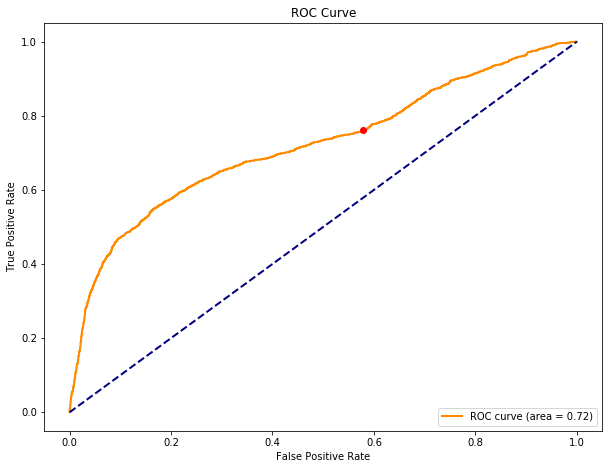

In [308]:
X, y, X_test, y_test = retrieve_dataset('baseline')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

# XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

In [313]:
# clf = XGBClassifier(seed=r, scale_pos_weight=3,
#                     learning_rate=0.1, n_estimators=100, 
#                     max_depth=3, min_child_weight=1,
#                     gamma=0.2, colsample_bytree=0.8, subsample=0.6)
clf = XGBClassifier(seed=r, scale_pos_weight=3, learning_rate=0.1, n_estimators=100)
# grid_search_cv(parameters={'scale_pos_weight':[1,2,3,4]}, n_folds=5, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_test = fit_and_score(clf, 'ale')

X_meta['XGB_ale'] = y_meta
X_meta_test['XGB_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.572	 f1_cv = 0.548 ± 0.021
f1_test = 0.541
cm_train = 
[[11957  2073]
 [ 1554  2428]]
cm_test = 
[[5831 1079]
 [ 834 1128]]


In [334]:
X, y, X_test, y_test = retrieve_dataset('orig')
add_dataset(X_meta, y, X_meta_test, y_test, 'meta')

In [337]:
X_meta.head(5)

,DT_baseline,NB_baseline,SVC_ale_pca,RFC_ale,KNNC_ale,MLPC_ale,LR_baseline,XGB_ale
0,1,1,0,0,0,0,1,1
1,0,0,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0


In [339]:
X_meta_test.head(5)

,DT_baseline,NB_baseline,SVC_ale_pca,RFC_ale,KNNC_ale,MLPC_ale,LR_baseline,XGB_ale
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


# Learning Ensemble - Level 2 algorithms

In [338]:
clf = XGBClassifier(seed=r, scale_pos_weight=3, learning_rate=0.1, n_estimators=100)
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.999	 f1_cv = 0.999 ± 0.001
f1_test = 0.335
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[5627 1283]
 [1310  652]]


(array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]))

In [332]:
X, y, X_test, y_test = retrieve_dataset('meta')
y_pred = (X.sum(axis=1) >= 2).apply(lambda x: 1 if x else 0)
y_pred_test = (X_test.sum(axis=1) >= 3).apply(lambda x: 1 if x else 0)

print(confusion_matrix(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))

[[5805 1105]
 [ 824 1138]]
0.541260404281


Evaluating on meta dataset
f1_train = 0.999	 f1_cv = 0.999 ± 0.001
f1_test = 0.335
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[5627 1283]
 [1310  652]]
[[ 0.28823086 -0.23430021  1.05453531  3.6159902   9.16227178  0.27322844
   0.20403198 -0.20714371]]


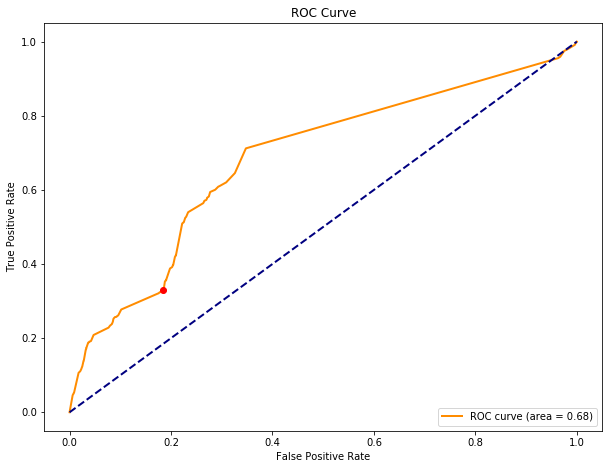

In [340]:
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=1)
fit_and_score(clf, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

In [341]:
clf = GaussianNB()
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.999	 f1_cv = 0.999 ± 0.001
f1_test = 0.335
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[5627 1283]
 [1310  652]]


(array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 1, ..., 0, 0, 0]))